In [1]:
from classy import Class           # Import classy module
import os
import copy
import yaml
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import scipy
from scipy.interpolate import interp1d

%config InlineBackend.figure_format = 'retina'

In [2]:
def m_a_conversion(m_a, h):    # Convert the unit of axion mass from eV to hubble
    h0_ev = h*100/3.086e19*scipy.constants.hbar/scipy.constants.e    # 1 Mpc = 3.086e19 km
    return m_a/h0_ev

In [3]:
# Calculate axion decay constant from other axion parameters
def cal_f_a(m_a, omega_a, theta_i, h, Omega_m):           # m_a in unit of eV
    h_eq = 2.3e-28    # in eV
    m_a_h0 = m_a_conversion(m_a, h)
    M_pl = np.sqrt(scipy.constants.hbar/8/np.pi/scipy.constants.G)*scipy.constants.c**2.5/scipy.constants.e    # M_planck
    phi_i2 = 0                                            # Initialize phi_i^2
    if m_a >= h_eq:
        phi_i2 = omega_a/5.23e-2/(Omega_m*h**2/0.143)**(3/4)/(m_a/1e-23)**0.5/(3407/3400)**(-3/4) # Assume z_eq = 3407
    elif m_a_h0 >= 1:
        phi_i2 = omega_a/3.62e-3/(Omega_m*h**2/0.143)
    f_a = np.sqrt(phi_i2)*1e26/theta_i/M_pl               # in unit of M_pl
    return f_a

In [4]:
# The parameters used here can refer to the .ini files for axion in Axiclass
# LCDM
h = 0.6766
omega_cdm = 0.11933
omega_b = 2.242e-02
Omega_m = (omega_cdm + omega_b)/h**2

# Create a set of cosmological parameters
cosmoLCDM = {
'omega_b': omega_b,
'A_s': 2.105e-9,
'h': h,
'n_s': 0.9665,
'tau_reio': 0.0561,
'T_cmb':2.725, 
'Omega_k': 0, 
'YHe': 0.24,
'P_k_max_h/Mpc': 10.,
# 'z_max_pk': 1,
'output':'tCl,pCl,lCl,mPk',
'lensing':'no',
'l_max_scalars': 3000
}

LCDM = Class()                       # Set up a class object
LCDM.set(cosmoLCDM)                  # Set cosmological parameters
LCDM.set({'omega_cdm':omega_cdm})    # Set cosmological parameters (omega_cdm)
LCDM.compute()                       # Execute class calculation

kk = np.array(np.logspace(-4, 1, 1000)*LCDM.h())  # Create an array of values of k
Pk_LCDM = np.array([LCDM.pk(ki, 0) for ki in kk]) # Obtain the matter power spectrum
Pk = np.stack((kk, Pk_LCDM))                      # Create a stack of array to store other sets of cosmology

# Normal axion
m_a = 1e-25    # Axion mass (in eV)

omega_a = 0.033
axion = Class()                           # Another class object (with axion)
axion.set(cosmoLCDM)                      # Reuse the common cosmological setup

# Parameters specific for cosmology with axion
axion_omega_cdm = omega_cdm - omega_a
cosmoaxion = {
'omega_cdm': axion_omega_cdm,
'Omega_scf': omega_a/h**2,
'm_axion': m_a_conversion(m_a, h),
'f_axion': cal_f_a(m_a, omega_a, 1, h, Omega_m),
'scf_parameters': r'%g, %g' % (cal_f_a(m_a, omega_a, 1, h, Omega_m), 0.),
#'scf_parameters__2': 0., 
'scf_potential': 'axion', 
'n_axion': 1, 
'scf_has_perturbations': 'yes', 
# 'attractor_ic_scf': 'no',
# 'do_shooting': 'yes',
# 'do_shooting_scf': 'yes',
# 'scf_tuning_index': 0,
# 'tol_shooting_deltax':1e-4,
# 'tol_shooting_deltaF':1e-4,
# 'background_verbose':10,
# 'thermodynamics_verbose':1,
'scf_evolve_as_fluid':'yes',
'scf_evolve_like_axionCAMB':'yes'
}
axion.set(cosmoaxion)
axion.compute()
Pk = np.concatenate((Pk, np.array([[axion.pk(ki, 0) for ki in kk]])), axis = 0)

# Extra axion
omega_a = 0.09
axion2 = Class()
axion2.set(cosmoLCDM)
axion_omega_cdm = omega_cdm - omega_a
cosmoaxion = {
'omega_cdm': axion_omega_cdm,
'Omega_scf': omega_a/h**2,
'm_axion': m_a_conversion(m_a, h),
'f_axion': cal_f_a(m_a, omega_a, 1, h, Omega_m),
'scf_parameters': r'%g, %g' % (cal_f_a(m_a, omega_a, 1, h, Omega_m), 0.),
'scf_potential': 'axion', 
'n_axion': 1, 
'scf_has_perturbations': 'yes', 
'scf_evolve_as_fluid':'yes',
'scf_evolve_like_axionCAMB':'yes'
}
axion2.set(cosmoaxion)
axion2.compute()
Pk = np.concatenate((Pk, np.array([[axion2.pk(ki, 0) for ki in kk]])), axis = 0)

# Axion + CDM isocurvature
omega_a = 0.09
axion_iso = Class()
axion_iso.set(cosmoLCDM)
axion_omega_cdm = omega_cdm - omega_a
cosmoaxion = {
'omega_cdm': axion_omega_cdm,
'Omega_scf': omega_a/h**2,
'm_axion': m_a_conversion(m_a, h),
'f_axion': cal_f_a(m_a, omega_a, 1, h, Omega_m),
'scf_parameters': r'%g, %g' % (cal_f_a(m_a, omega_a, 1, h, Omega_m), 0.),
'scf_potential': 'axion', 
'n_axion': 1, 
'scf_has_perturbations': 'yes', 
'scf_evolve_as_fluid':'yes',
'scf_evolve_like_axionCAMB':'yes'
}
isocurvature = {
'ic':'ad, cdi', 
'f_cdi':np.sqrt(13), 
'n_cdi':4
}
axion_iso.set(cosmoaxion)
axion_iso.set(isocurvature)
axion_iso.compute()
Pk = np.concatenate((Pk, np.array([[axion_iso.pk(ki, 0) for ki in kk]])), axis = 0)

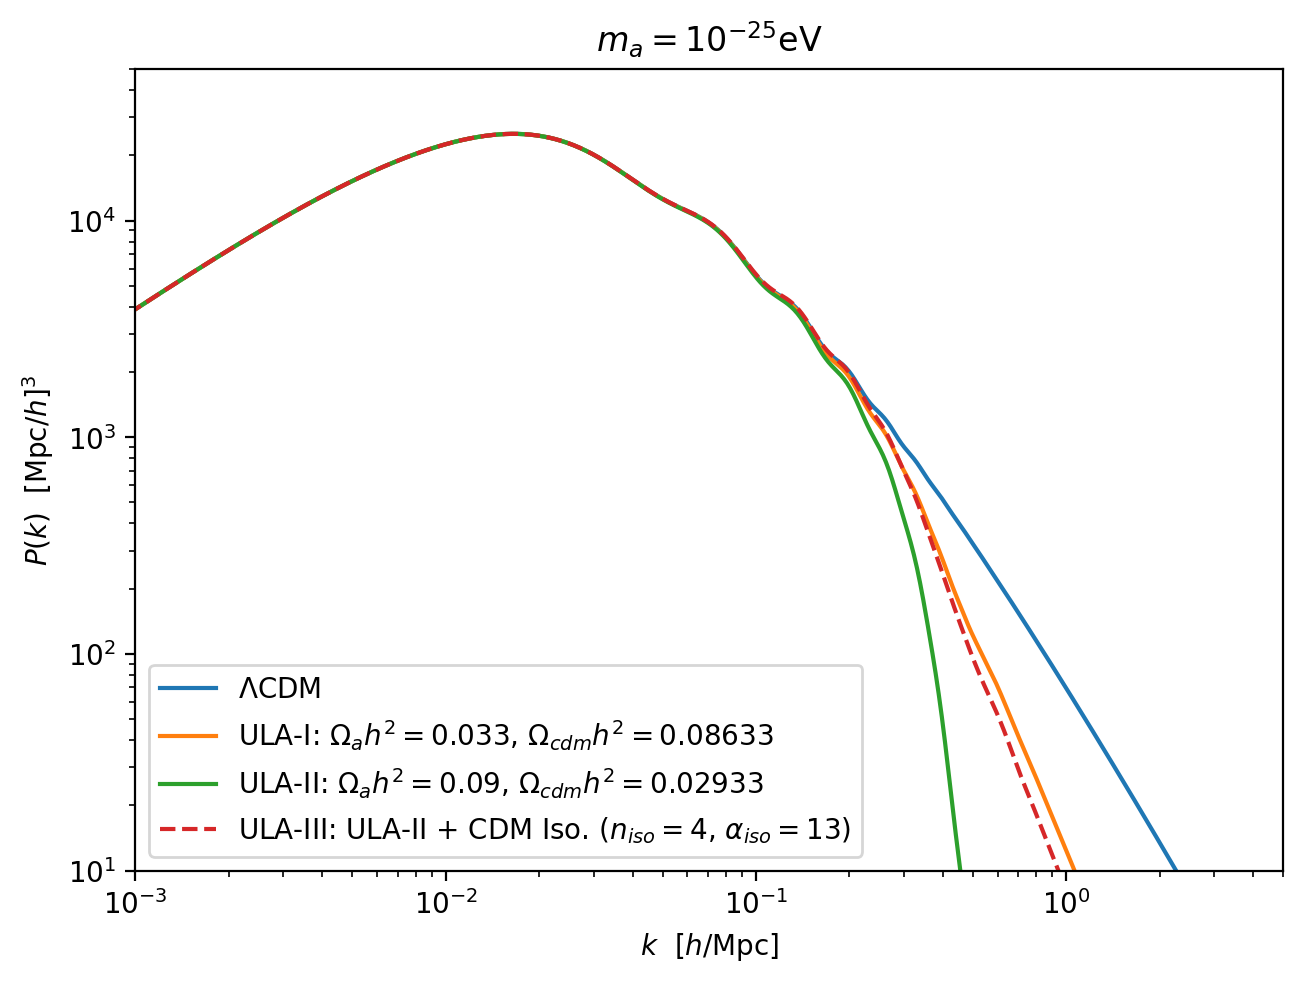

In [5]:
fig, (ax) = plt.subplots(1, 1, constrained_layout=True)
ax.set_title(r"$m_a =10^{-25}$eV")
ax.plot(kk/LCDM.h(), Pk[1, :]*LCDM.h()**3, label=r"$\Lambda$CDM")
ax.plot(kk/axion.h(), Pk[2, :]*axion.h()**3, label=r"ULA-I: $\Omega_a h^2 =0.033$, $\Omega_{cdm} h^2 =0.08633$")
ax.plot(kk/axion2.h(), Pk[3, :]*axion2.h()**3, label=r"ULA-II: $\Omega_a h^2 =$"+str(omega_a)+r", $\Omega_{cdm} h^2 =0.02933$")
ax.plot(kk/axion_iso.h(), Pk[4, :]*axion_iso.h()**3, label=r"ULA-III: ULA-II + CDM Iso. ($n_{iso}=4$, $\alpha_{iso}=13$)", ls='dashed')
ax.set_xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
ax.set_ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
ax.set_xlim(1e-3, 5)
ax.set_ylim(1e1, 5e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
# plt.savefig("pkratio_ma25.pdf")